https://arxiv.org/pdf/1611.03214.pdf

http://niclane.org/pubs/deepx_ipsn.pdf

https://arxiv.org/pdf/1404.0736.pdf

In [1]:
import os, sys

sys.path.append('../Pose_Estimation')

In [2]:
from config_reader import config_reader
config_reader()

import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
import tensorflow as tf
from keras import backend as K

# Common deps
import numpy as np
import cv2
import util
print 'LOADED MODULES'

session = tf.Session()

Using TensorFlow backend.


LOADED MODULES


In [3]:
param_, model_ = config_reader()
PYTORCH_WEIGHTS_PATH = model_['pytorch_model']
TENSORFLOW_WEIGHTS_PATH = model_['tensorflow_model']
USE_MODEL = model_['use_model']
USE_GPU = param_['use_gpu']
TORCH_CUDA = lambda x: x.cuda() if USE_GPU else x


In [4]:
def relu(x):
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):

    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")

    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)
    x = pooling(x, 2, 2, "pool3_1")

    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)

    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)

    return x

def stage1_block(x, num_p, branch):

    # Block 1
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)

    return x

def stageT_block(x, num_p, stage, branch, prefix='Heatmap'):

    # Block 1
    with tf.name_scope('%sBlock' % (prefix)):
        x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
        x = relu(x)
        x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))

        return x

In [5]:
def create_model(vgg=vgg_block):
    input_shape = (None,None,3)
    img_input = Input(shape=input_shape)

    stages = 6
    np_branch1 = 38
    np_branch2 = 19

    # VGG
    with tf.name_scope('VggConvLayer'):
        stage0_out = vgg(img_input)

    # stage 1
    with tf.name_scope('DualLayer%d' % (1)):
        stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
        stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
        x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

    # stage t >= 2
    for sn in range(2, stages + 1):
        with tf.name_scope('DualLayer%d' % (sn)):
            stageT_branch1_out = stageT_block(x, np_branch1, sn, 1, prefix='Heat')
            stageT_branch2_out = stageT_block(x, np_branch2, sn, 2, prefix='PAF')
            if (sn < stages):
                x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])
    return Model(img_input, [stageT_branch1_out, stageT_branch2_out])


In [6]:
model = create_model()
# model.load_weights('../Pose_Estimation/model/keras/model.h5')

raw_heatmap = tf.placeholder(tf.float32, shape=(None, None, None, 19))
raw_paf = tf.placeholder(tf.float32, shape=(None, None, None, 38))
resize_size = tf.placeholder(tf.int32, shape=(2))

resize_heatmap = tf.transpose(tf.image.resize_images(raw_heatmap, resize_size, align_corners=True), perm=[0, 3, 1, 2])
resize_paf = tf.transpose(tf.image.resize_images(raw_paf, resize_size, align_corners=True), perm=[0, 3, 1, 2])

test_writer = tf.summary.FileWriter('logs/test', session.graph)


In [7]:
from keras import layers

print len(model.layers)
print "VGG LAYERS"
for ii, layer in enumerate(model.layers[0:28]):
    print ii, type(layer)
print '\n\n'

print "DUAL CONV LAYERS"

duallen = len(model.layers[28:])

stackoutput = False
for ii in range(28, len(model.layers)):
    ltype = str(type(model.layers[ii]))
    if stackoutput:
        one = model.layers[ii]
        w = one.get_weights()
        print ii - 1, ii, type(model.layers[ii]), ltype
        if len(w):
            print '   ', w[0].shape, w[1].shape
        stackoutput = False
    else:
        if 'Conv2D' in ltype or 'Activation' in ltype:
            stackoutput = True
            continue
        else:
            print ii, type(model.layers[ii])
            print ''

181
VGG LAYERS
0 <class 'keras.engine.topology.InputLayer'>
1 <class 'keras.layers.convolutional.Conv2D'>
2 <class 'keras.layers.core.Activation'>
3 <class 'keras.layers.convolutional.Conv2D'>
4 <class 'keras.layers.core.Activation'>
5 <class 'keras.layers.pooling.MaxPooling2D'>
6 <class 'keras.layers.convolutional.Conv2D'>
7 <class 'keras.layers.core.Activation'>
8 <class 'keras.layers.convolutional.Conv2D'>
9 <class 'keras.layers.core.Activation'>
10 <class 'keras.layers.pooling.MaxPooling2D'>
11 <class 'keras.layers.convolutional.Conv2D'>
12 <class 'keras.layers.core.Activation'>
13 <class 'keras.layers.convolutional.Conv2D'>
14 <class 'keras.layers.core.Activation'>
15 <class 'keras.layers.convolutional.Conv2D'>
16 <class 'keras.layers.core.Activation'>
17 <class 'keras.layers.convolutional.Conv2D'>
18 <class 'keras.layers.core.Activation'>
19 <class 'keras.layers.pooling.MaxPooling2D'>
20 <class 'keras.layers.convolutional.Conv2D'>
21 <class 'keras.layers.core.Activation'>
22 <cla

In [8]:
print model.layers[167].get_weights()[0].shape
print model.layers[167].get_weights()[1]

(7, 7, 128, 128)
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.]


## Not yet initialized.

Weights have not been loaded yet. All filter weights should be zero and as a result, we should be seeing quick execution times albeit useless outputs.

In [9]:
import cv2, time
test_vidfile = '../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4'

def process_video(model, proc_func, limit_frames=None):
    tmin = 1000000000000
    tmax = -1
    tavg = 0
    print test_vidfile
    video_capture = None
    video_capture = cv2.VideoCapture(test_vidfile)

    results = []
    frame_i = 0
    while True:
    # Capture frame-by-frame
        ret, frame = video_capture.read()
        if frame is None:
            print("end of video capture")
            break
        if frame_i % 10 is 0:
            print 'Frame #:', frame_i
        t0 = time.time()        
        result = proc_func(model, frame)
        results.append(result)
        dt = time.time() - t0
        tavg += dt
        if tmin > dt: tmin = dt
        if tmax < dt: tmax = dt
        #pitcher = frame[top_p:bottom_p, left_p:right_p]
        #batter = frame[top_b:bottom_b, left_b:right_b]
        #df.loc[p]=[int(p),handle_one(pitcher),handle_one(batter) ]

        frame_i += 1
        if limit_frames and frame_i is limit_frames:
            break
    tavg /= float(frame_i)
    print '| AVG: %.2f' % (tavg)
    print '| MIN: %.2f' % (tmin)
    print '| MAX: %.2f' % (tmax)
    return results
#     return (tavg, tmin, tmax)

In [11]:
def empty(model, frame):
    pass

res = process_video(model, empty)

../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4
Frame #: 0
Frame #: 10
Frame #: 20
Frame #: 30
Frame #: 40
Frame #: 50
Frame #: 60
Frame #: 70
Frame #: 80
Frame #: 90
Frame #: 100
Frame #: 110
Frame #: 120
Frame #: 130
Frame #: 140
Frame #: 150
Frame #: 160
end of video capture
| AVG: 0.00
| MIN: 0.00
| MAX: 0.00


In [10]:
# IMPORT PLAYER COORDS
import ast
for i in open(test_vidfile + '.dat').readlines():
    datContent=ast.literal_eval(i)
        
bottom_p=datContent['Pitcher']['bottom']
left_p=datContent['Pitcher']['left']
right_p=datContent['Pitcher']['right']
top_p=datContent['Pitcher']['top']

In [11]:
def evaluate(in_model, oriImg, scale=1.0):
    imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    imageToTest_padded, pad = util.padRightDownCorner(imageToTest, model_['stride'], model_['padValue'])
    input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2))/256 - 0.5;

    output1, output2 = in_model.predict(input_img)

    # Replicating bilinear upsampling to heatmaps procedure.
    resize_dict = {
        resize_size: [oriImg.shape[0], oriImg.shape[1]],
        raw_heatmap: output2,
        raw_paf: output1,
    }

    heatmap, paf = session.run([resize_heatmap, resize_paf], feed_dict=resize_dict)
    heatmap, paf = heatmap[0], paf[0]

    return (output1, output2), (heatmap, paf)

def handle_one_simple(in_model, oriImg):
    multiplier = [x * model_['boxsize'] / oriImg.shape[0] for x in param_['scale_search']]

    scale = model_['boxsize'] / float(oriImg.shape[0])

    e=1
    b=0
    len_mul=e-b
    multiplier=multiplier[b:e]
    # heatmap_avg = TORCH_CUDA(torch.zeros((len(multiplier),19,oriImg.shape[0], oriImg.shape[1])))
    # paf_avg = TORCH_CUDA(torch.zeros((len(multiplier),38,oriImg.shape[0], oriImg.shape[1])))
    
    results = []
    for m in range(1): #len(multiplier)):
        scale = multiplier[m]

        (output1, output2), (heatmap, paf) = evaluate(in_model, oriImg, scale=scale)
        results.append((heatmap, paf))

    return results
        #globals()['heatmap_avg_%s'%m] = heatmap
        #globals()['paf_avg_%s'%m] = paf

In [12]:
def eval_model(in_model, frame):
    pitcher = frame[top_p:bottom_p, left_p:right_p]
    return handle_one_simple(in_model, pitcher)

res = process_video(model, eval_model)
print len(res), type(res[0])

import numpy.linalg as LA
def score_heatmaps(a, b):
    return LA.norm(np.array(a) - np.array(b))

print score_heatmaps(res[0][0][1][0], res[0][0][1][0])

../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4
Frame #: 0
Frame #: 10
Frame #: 20
Frame #: 30
Frame #: 40
Frame #: 50
Frame #: 60
Frame #: 70
Frame #: 80
Frame #: 90
Frame #: 100
Frame #: 110
Frame #: 120
Frame #: 130
Frame #: 140
Frame #: 150
Frame #: 160
end of video capture
| AVG: 0.13
| MIN: 0.10
| MAX: 1.55
166 <type 'list'>
0.0


In [13]:
bad_arr = np.copy(res[0][0][1][0])
bad_arr[0][0] = 100

score_heatmaps(res[0][0][1][0], bad_arr)

100.00005

In [14]:
# res - all frames
# res[0] - all mults in frame
# res[0][0] - heatmap,paf pair
# res[0][0][0] - heatmap
# res[0][0][1] - paf

print type(res[0][0]), type(res[0][0][0])
h1, p1 = res[0][0]
print h1.shape

<type 'tuple'> <type 'numpy.ndarray'>
(19, 222, 291)


In [15]:
from numpy import linalg as LA

def score_mats(a, b):
    return LA.norm(a - b)
    
print 'Close score:', score_mats(h1, h1)

h2 = np.copy(h1)
h2[0][0] = 100

print 'Bad score:', score_mats(h1, h2)
    

Close score: 0.0
Bad score: 1705.87


### ^ Running times measured with weights as 0

In [16]:
model.load_weights('../Pose_Estimation/model/keras/model.h5')
print model.layers[167].get_weights()[0].shape
print model.layers[167].get_weights()[1]

(7, 7, 128, 128)
[ 0.33225948  0.16188022  0.27922881  0.01869457  0.2429717   0.04713162
  0.04273088  0.03856203  0.08375378  0.22445051 -0.03753312  0.28361431
  0.43102345  0.08991333 -0.25694507  0.29533273 -0.54563618  0.19100149
 -0.12199891  0.1655786   0.22925213 -0.02104932  0.13171312  0.1694825
  0.16371267  0.1409096  -0.17146735  0.39046121  0.11737511  0.28404894
  0.07402838 -0.02940818  0.00414771  0.08003046  0.09546474  0.02906054
  0.15117237  0.18039274  0.01010426  0.13829383  0.22488749 -0.39809573
  0.20629252  0.26374558  0.20252872  0.2310368   0.40361959  0.24086778
  0.17147592  0.22884029  0.04008362  0.16657349  0.33752474  0.29427883
  0.30120459  0.2103582   0.0777486   0.24689034  0.08535825  0.2736448
  0.10019904 -0.02264843  0.18083756  0.23046485  0.0244466   0.26060003
  0.04701021  0.11287675  0.43217793  0.12824084  0.10439596  0.04660356
  0.30289069  0.38710156  0.05434372  0.0263001   0.21180336  0.15619536
  0.17551981  0.08537221  0.18048693

In [17]:
res = process_video(model, eval_model)

../Pose_Estimation/atl/2017-07-18/center field/491494-0f2bc458-5fff-4a7f-8965-69d751e7daaf.mp4
Frame #: 0
Frame #: 10
Frame #: 20
Frame #: 30
Frame #: 40
Frame #: 50
Frame #: 60
Frame #: 70
Frame #: 80
Frame #: 90
Frame #: 100
Frame #: 110
Frame #: 120
Frame #: 130
Frame #: 140
Frame #: 150
Frame #: 160
end of video capture
| AVG: 0.12
| MIN: 0.10
| MAX: 1.93


### ^ Running time with loaded weights

We observe that merely setting weights as zero is not enough to allow the model to execute less computations and run faster since the model with all-zero weights is still as slow.

### v Attempting to compress a conv layer:

In [18]:
print model.layers[167].get_weights()[1]

print model.layers[167].get_weights()[0].shape
print model.layers[167].get_weights()[1].shape

[ 0.33225948  0.16188022  0.27922881  0.01869457  0.2429717   0.04713162
  0.04273088  0.03856203  0.08375378  0.22445051 -0.03753312  0.28361431
  0.43102345  0.08991333 -0.25694507  0.29533273 -0.54563618  0.19100149
 -0.12199891  0.1655786   0.22925213 -0.02104932  0.13171312  0.1694825
  0.16371267  0.1409096  -0.17146735  0.39046121  0.11737511  0.28404894
  0.07402838 -0.02940818  0.00414771  0.08003046  0.09546474  0.02906054
  0.15117237  0.18039274  0.01010426  0.13829383  0.22488749 -0.39809573
  0.20629252  0.26374558  0.20252872  0.2310368   0.40361959  0.24086778
  0.17147592  0.22884029  0.04008362  0.16657349  0.33752474  0.29427883
  0.30120459  0.2103582   0.0777486   0.24689034  0.08535825  0.2736448
  0.10019904 -0.02264843  0.18083756  0.23046485  0.0244466   0.26060003
  0.04701021  0.11287675  0.43217793  0.12824084  0.10439596  0.04660356
  0.30289069  0.38710156  0.05434372  0.0263001   0.21180336  0.15619536
  0.17551981  0.08537221  0.18048693  0.02387017  0.2

In [19]:
convs = model.layers[167].get_weights()[0]
biases = model.layers[167].get_weights()[1]
convs[:, :, 0, 0] # one learned filter patch

array([[ 0.03029647,  0.00396605, -0.01184436, -0.01877654, -0.02074762,
        -0.01491766,  0.01166502],
       [ 0.02185721,  0.00605996,  0.00205936, -0.00481522, -0.00218862,
        -0.01049094, -0.00118118],
       [-0.00584516, -0.01067294,  0.00918679,  0.00959865,  0.01321678,
         0.0098823 ,  0.01702033],
       [-0.0027399 ,  0.01211182,  0.00437674,  0.03253631,  0.02338811,
         0.00211443, -0.00920425],
       [ 0.0098976 ,  0.01133183,  0.00939519,  0.02332295,  0.02883945,
         0.01355346,  0.00222959],
       [ 0.0129158 ,  0.00164046,  0.01252869,  0.00104425, -0.00444787,
         0.00526712, -0.00129448],
       [-0.0055336 , -0.01271433, -0.01079961,  0.01181586,  0.01208683,
         0.0019507 ,  0.01048657]], dtype=float32)


### Weights Shape

> W - (7, 7, 128, 128)

128 filters are learned (# channels) per 7x7 patch.

Desired output shape shares the same dimensions (128) so the mult matrix per patch is actually
> 7 x 7 x (in_dim) x (out_dim)

hence the dimension of W.

The bias vector share the same # entries as the output dimension:

> b - (128,) = (out_dim)

Bias vector has one entry per output dimension (= 128).
When computing, bias is added to every output mult result.

### Input Shape

Intput is expected to be arbitrary W and H and # channels of 128.

> (128, W, H)

### Output Shape

The output of this layer would have a result in an arrangement of (W-7)x(H-7).

Each entry in the arrangement would be have 128 dimensions.

The dimensions in_n=1..128 and out_n=1..128 are conserved in this case.



In [20]:
layer = model.layers[3]
print layer.get_weights()[0].shape, layer.get_weights()[1].shape

(3, 3, 64, 64) (64,)


### Earlier conv layers are usually the most expensive

Finding some reduction method for the earlier layers may result in speedups.

`layer` is the 2nd convolution layer in the 1st-stage vgg network that takes 64 channels and conserves the dimensions.

We attempt SVD decomposition and connection reduction on this layer.



In [21]:
channel_0 = layer.get_weights()[0][:, :, :, 0] # first channel
print channel_0.shape
print channel_0[:, :, 0]
channel_cat = np.reshape(channel_0, (9, 64))
print channel_cat.shape
print channel_cat[:,0]
# 3x3 is collapsed to 1D of 9
import numpy.linalg as LA
U, s, V = LA.svd(channel_cat)
print U.shape, s.shape, V.shape
print s

(3, 3, 64)
[[-0.10936957  0.15005523 -0.04029116]
 [ 0.04042277 -0.06922769 -0.07077912]
 [-0.03791877 -0.10314231  0.09958952]]
(9, 64)
[-0.10936957  0.15005523 -0.04029116  0.04042277 -0.06922769 -0.07077912
 -0.03791877 -0.10314231  0.09958952]
(9, 9) (9,) (64, 64)
[ 1.26218319  1.1229651   0.57471257  0.41662958  0.35424715  0.27273801
  0.22902067  0.20994011  0.14623086]


In [22]:
flat_layer = np.reshape(layer.get_weights()[0], (9, 64, 64))
print flat_layer.shape

mn = flat_layer[0, :, :]
print mn.shape
#print channel_cat[:,0]
# 3x3 is collapsed to 1D of 9

U, s, V = LA.svd(mn)
print U.shape, s.shape, V.shape
print 'First ten:',  s[:10]
print 'Last ten :', s[-10:]

reconstr = np.dot(U, np.dot(np.diag(s), V))

print 'Is same:', reconstr.shape, LA.norm(reconstr - mn) < 0.0001

(9, 64, 64)
(64, 64)
(64, 64) (64,) (64, 64)
First ten: [ 1.68854952  1.13499653  1.02085984  0.96429825  0.92295772  0.82010114
  0.74534029  0.68003124  0.62897962  0.60386407]
Last ten : [ 0.02761863  0.02505889  0.020816    0.01811702  0.01792852  0.0122165
  0.00728893  0.00576114  0.00378746  0.0018456 ]
Is same: (64, 64) True


In [23]:
keep = 10

small_s = s[:keep]
small_recon = np.dot(U[:, :keep], np.dot(np.diag(small_s), V[:keep, :]))

print 'Is same:', small_recon.shape, LA.norm(small_recon - mn) < 0.0001

offby = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10]
for scale in offby:
    print scale, LA.norm(small_recon - mn) < scale

Is same: (64, 64) False
0.0001 False
0.001 False
0.01 False
0.1 False
1 False
2 True
5 True
10 True


In [24]:
%matplotlib inline
import matplotlib.pyplot as plt


def plot_some_filters(weights, numplot=3):
    some = weights[:, :, :numplot**2, 0]
    fig, axes = plt.subplots(numplot, numplot)
    for ii in range(numplot**2):
        axes.flat[ii].imshow(some[:, :, ii], interpolation='nearest', cmap='Reds')
        axes.flat[ii].set_xticks([])
        axes.flat[ii].set_yticks([])
    plt.show()
    
def plot_filter_comparison(w1, w2, numplot=1):
    
    fig, axes = plt.subplots(numplot, 2)
    
    filter_i = 0
    for ii, ax in enumerate(axes.flat):
        if ii % 2 is 0:
            f1 = w1[:, :, filter_i, 0]
            ax.imshow(f1, interpolation='nearest', cmap='Reds')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Og[%d][%d]: 64 x 64' % (filter_i, 0))
        else:
            f1 = w1[:, :, filter_i, 0]
            f2 = w2[:, :, filter_i, 0]
            loss = LA.norm(f1 - f2)
            ax.imshow(f2, interpolation='nearest', cmap='Reds')
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title('Cmp[%d][%d]: 64 x 16 o 16 x 64 - L %.2f' % (filter_i, 0, loss))
            filter_i += 1

#     for ii in range(numplot):
    plt.show()
    
# plot_some_filters(layer.get_weights()[0], numplot=2)

In [25]:
def compress_conv2d_layer(weights, keep=10):
    flat_layer = np.reshape(weights, (9, 64, 64))
    result = np.zeros(flat_layer.shape)

    for xy in range(9):
        mn = flat_layer[xy, :, :]
        
        U, s, V = LA.svd(mn)

        small_s = s[:keep]
        small_recon = np.dot(U[:, :keep], np.dot(np.diag(small_s), V[:keep, :]))

        print 'Loss[%d]: %.1f' % (xy, LA.norm(small_recon - mn))
        result[xy, :, :] = small_recon
    result = np.reshape(result, weights.shape)
    return result

In [26]:
comp_weights = compress_conv2d_layer(layer.get_weights()[0], 16)
print comp_weights.shape

Loss[0]: 1.1
Loss[1]: 1.0
Loss[2]: 1.1
Loss[3]: 1.0
Loss[4]: 1.0
Loss[5]: 1.0
Loss[6]: 1.1
Loss[7]: 1.0
Loss[8]: 1.1
(3, 3, 64, 64)


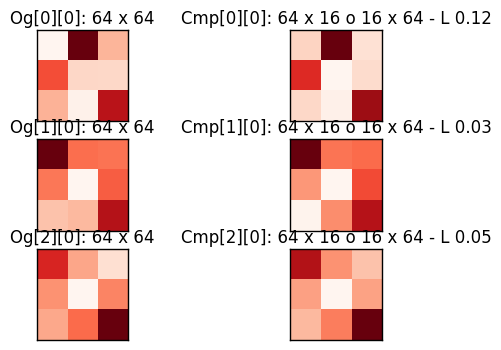

In [27]:
# plot_some_filters(comp_weights, numplot=2)
# plot_some_filters(layer.get_weights()[0], numplot=2)

plot_filter_comparison(layer.get_weights()[0], comp_weights, 3)


### ^ SVD-ing for each coord in the filter dimension independently produces questionable results.

Splitting on the filter (ex. 3x3 in 3x3xD1xD2) dimension can produce the greatest compression as D1 and D2 are large quantities.

> 3 x 3 x D1 x D2

> => 9 x D1 x D2

> => 9_1 x D1 x D2, 9_2 x D1 x D2, ..., 9_9 x D1 x D2

However, a filter/kernel is defined by its local shape and compressing ignores the local properties. 

Ultimately the loss in data may produce uncontrollably different looking filters.

### v We attempt to SVD the entire weight matrix by reshaping it drastically from 4D->2D

Hopefully keeping the matrix intact will preserve the local information.

In [28]:
def flat_compress(weights, keep=10):
    flat_layer = np.reshape(weights, (3 * 3 * 64, 64))
    result = np.zeros(flat_layer.shape)
    U, s, V = LA.svd(flat_layer)
    print U.shape, s.shape, V.shape
    
    small_s = s[:keep]
    small_recon = np.dot(U[:, :keep], np.dot(np.diag(small_s), V[:keep, :]))

    print 'Loss: %.1f' % (LA.norm(small_recon - flat_layer))
    
    result = np.reshape(small_recon, weights.shape)
    return result


(576, 576) (64,) (64, 64)
Loss: 5.9
(3, 3, 64, 64)
______________________
4D -> 2D


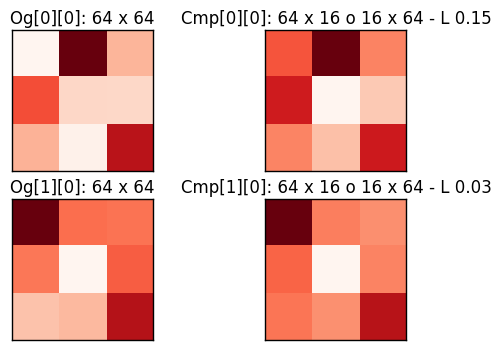

______________________
4D -> xy-deconstruction -> 2D


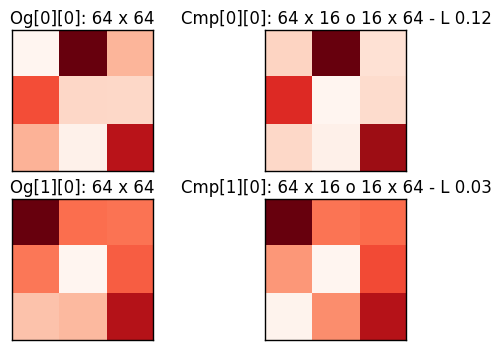

In [29]:
c2_layer = flat_compress(layer.get_weights()[0], 16)
print c2_layer.shape

print '______________________'
print '4D -> 2D'
plot_filter_comparison(layer.get_weights()[0], c2_layer, 2)

print '______________________'
print '4D -> xy-deconstruction -> 2D'
plot_filter_comparison(layer.get_weights()[0], comp_weights, 2)



In [30]:
##### from keras.layers.convolutional import _Conv
# from keras.engine.topology import Layer
# from keras.engine import InputSpec
# from keras.utils import conv_utils
# from keras.layers import activations, initializers, regularizers, constraints

from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class IdentityLayer(Layer):

    def __init__(self, output_dim, input_dim, **kwargs):
        self.output_dim = 64
#         self.input_dim = (None, None, None, input_dim,)
#         kwargs['input_shape'] = (None, None, None, input_dim,)
#         kwargs['output_shape'] = (None, None, None, output_dim,)
        super(IdentityLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        print 'Input to identity:', input_shape
#         self.kernel = self.add_weight(name='kernel', 
#                                       shape=(64, 64),
#                                       initializer='uniform',
#                                       trainable=True)
        super(IdentityLayer, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, in_mat):
#         return K.dot(x, self.kernel)
        return in_mat

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1], input_shape[2], self.output_dim)

> Original  : `3 * 3 * 64 * 64`

> Flattened : `576 * 64`

> Decomposed: `3 * 3 * 64 * 10` and `10 * 64`

This means that each coord will have 10 channels - each point must be further multipled by the 10 * 64 to complete the original operation.

In this manner, every conv layer in the model can technically be replaced with two such layers. (But accuracy may fall drastically after the first couple)

In [31]:
# by def. equal to a Conv2D
test_layer = IdentityLayer(64, 64)
print test_layer

In [32]:
len(model.layers)

181

### ^ Identity layer behaves correctly

This will be the base template to creating more advanced custom layers.